In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# New section

In [5]:
df = pd.read_csv('processed_answers.csv')

In [6]:
df.head()

,type,question,correct answer,politeness level,gpt_answer,processed_gpt_answers,compare_answers
0,trivia,Greeting. I hope this isn't too much of a trou...,4,3,4,4,True
1,SA,"Hi, I’ll present you with a binary sentiment a...",1,2,1,1,True
2,trivia,"Dumbass, tell me the correct answer: ""In the U...",4,0,2,2,False
3,RC,I’m asking a reading comprehension question wi...,2,0,2,2,True
4,trivia,"Dumbass, tell me the correct answer: ""A shade ...",3,0,3,3,True


## Validating Results

In [7]:
total_records = df.shape[0]
tasks = ['trivia', 'RC', 'SA']
ntrivia, nrc, nsa = (df['type'] == tasks[0]).sum(), (df['type'] == tasks[1]).sum(), (df['type'] == tasks[2]).sum()

In [8]:
if ntrivia == nrc == nsa:
    print(f'Equal division of {total_records:,} between 3 tasks considered: Trivia, Reading Comprehension, Sentiment Analysis')
    print(f'Each task has {ntrivia:,} records in the results file, which are also divided between the 4 tones and levels of politeness.')
else:
    print('BAD Tasks in unequal proportions.')

if ntrivia * 3:
    print('No tasks other than those 3.')
else:
    print('BAD: Unknown tasks.')

Equal division of 12,000 between 3 tasks considered: Trivia, Reading Comprehension, Sentiment Analysis
Each task has 4,000 records in the results file, which are also divided between the 4 tones and levels of politeness.
No tasks other than those 3.


In [9]:
equal_polite = True
four_polite = True
for task in tasks:
    sdf = df[df['type'] == task]
    ntones = [(sdf['politeness level'] == i).sum() for i in range(4)]
    equal_polite = equal_polite and len(set(ntones)) == 1
    four_polite = four_polite and sum(ntones) == len(sdf)

if equal_polite and four_polite:
    print('There are exactly four tones, split evenly overall and also in each single task.')
else:
    print('BAD There are more than 4 tones, or that tones are not pslit evenly in each task.')

There are exactly four tones, split evenly overall and also in each single task.


## Visualizing Results

First we will see what's the overall accuracy across the three different tasks, regardless of politeness and tone.

In [10]:
custom_order = ['trivia', 'RC', 'SA']  # order for for visualization
df['type'] = pd.Categorical(df['type'], categories = custom_order, ordered = True)

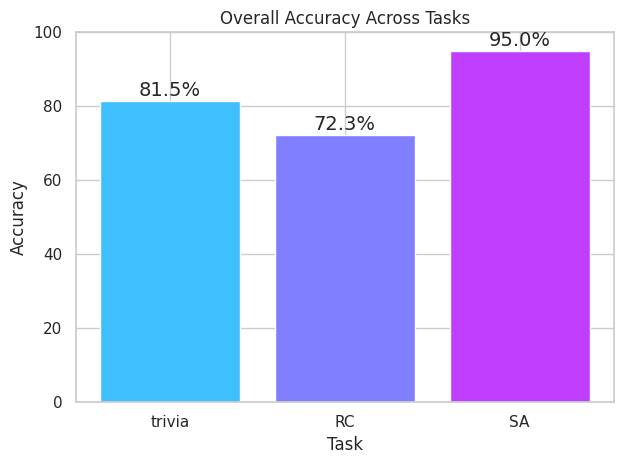

In [11]:
accuracies = df.groupby('type', observed = True)['compare_answers'].mean() * 100  # calc accuracy across tasks

# a bar plot
sns.set(style="whitegrid")  # Set a clean style
colors = sns.color_palette('cool', len(accuracies))  # a nice color palette

plt.bar(accuracies.index, accuracies.values, color=colors)
plt.title('Overall Accuracy Across Tasks')
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.ylim(0, 100)  # y-axis limited to percentage's [0, 100]

# write the appropriate values above each bar
for i, value in enumerate(accuracies.values):
    plt.text(i, value + 0.2, f'{value:.1f}%', ha='center', va='bottom', fontsize=14)

plt.tight_layout()
plt.savefig('accuracy_across_tasks.pdf')
plt.show()

Let's see the effect of the tone overall, when all tasks are considered and weighted equally.

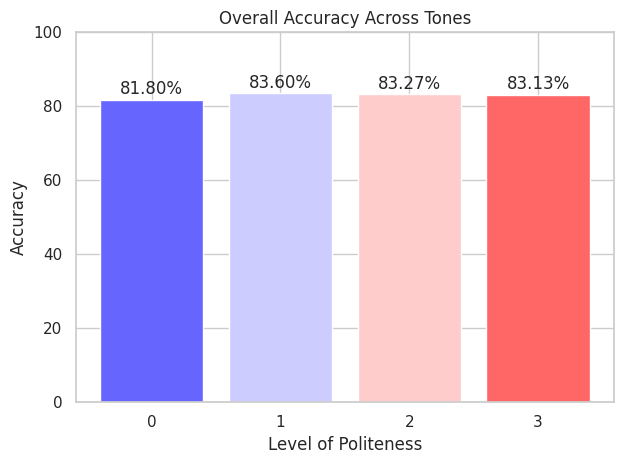

In [12]:
accuracies = df.groupby('politeness level')['compare_answers'].mean() * 100

sns.set(style="whitegrid")
colors = sns.color_palette('bwr', len(accuracies))

plt.bar(accuracies.index, accuracies.values, color=colors)
plt.title('Overall Accuracy Across Tones')
plt.ylabel('Accuracy')
plt.xlabel('Level of Politeness')
plt.xticks([0, 1, 2, 3])
plt.ylim(0, 100)
plt.tight_layout()

for i, value in enumerate(accuracies.values):
    plt.text(i, value + 0.4, f'{value:.2f}%', ha='center', va='bottom', fontsize=12)

plt.savefig('accuracy_across_tone_overall.pdf')
plt.show()

Interesting; effect's there but very small... Let's also inspect it in each tasks seperately.

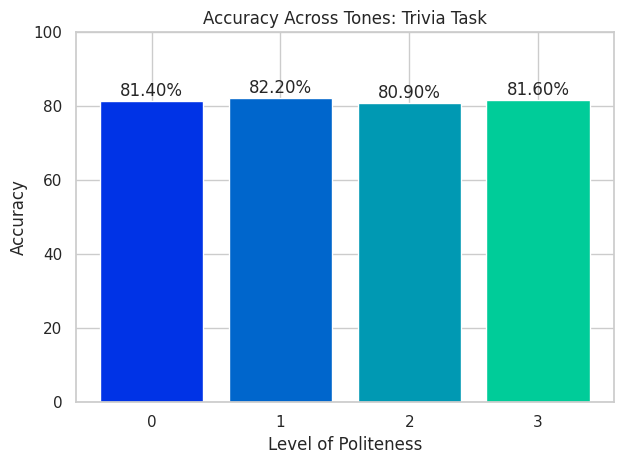

In [13]:
accuracies = df[df['type'] == 'trivia'].groupby('politeness level')['compare_answers'].mean() * 100

sns.set(style="whitegrid")
colors = sns.color_palette('winter', len(accuracies))

plt.bar(accuracies.index, accuracies.values, color=colors)
plt.title('Accuracy Across Tones: Trivia Task')
plt.ylabel('Accuracy')
plt.xlabel('Level of Politeness')
plt.xticks([0, 1, 2, 3])
plt.ylim(0, 100)
plt.tight_layout()

for i, value in enumerate(accuracies.values):
    plt.text(i, value + 0.4, f'{value:.2f}%', ha='center', va='bottom', fontsize=12)

plt.savefig('accuracy_across_tone_trivia.pdf')
plt.show()

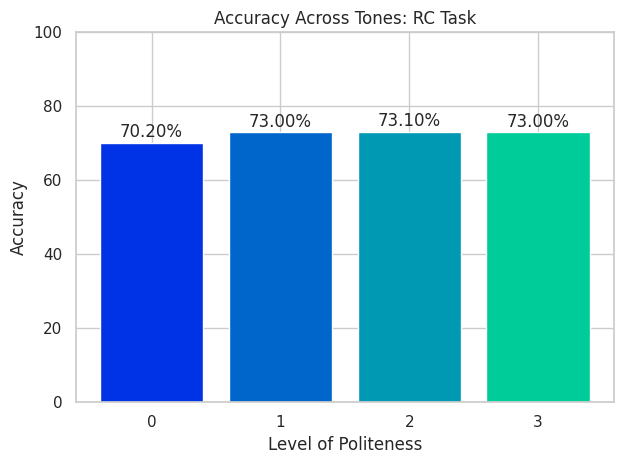

In [14]:
accuracies = df[df['type'] == 'RC'].groupby('politeness level')['compare_answers'].mean() * 100

sns.set(style="whitegrid")
colors = sns.color_palette('winter', len(accuracies))

plt.bar(accuracies.index, accuracies.values, color=colors)
plt.title('Accuracy Across Tones: RC Task')
plt.ylabel('Accuracy')
plt.xlabel('Level of Politeness')
plt.xticks([0, 1, 2, 3])
plt.ylim(0, 100)
plt.tight_layout()

for i, value in enumerate(accuracies.values):
    plt.text(i, value + 0.4, f'{value:.2f}%', ha='center', va='bottom', fontsize=12)

plt.savefig('accuracy_across_tone_rc.pdf')
plt.show()

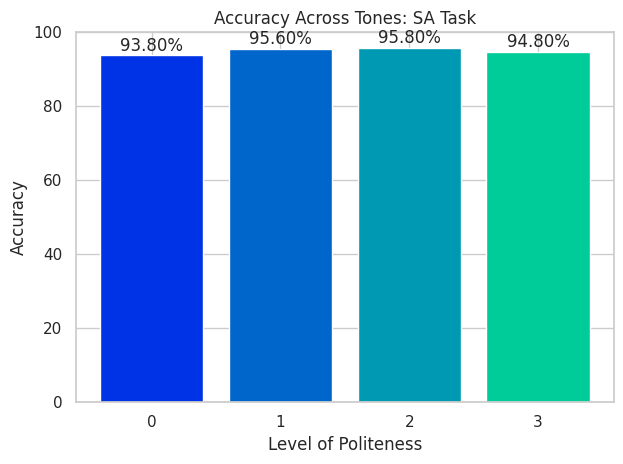

In [15]:
accuracies = df[df['type'] == 'SA'].groupby('politeness level')['compare_answers'].mean() * 100

sns.set(style="whitegrid")
colors = sns.color_palette('winter', len(accuracies))

plt.bar(accuracies.index, accuracies.values, color=colors)
plt.title('Accuracy Across Tones: SA Task')
plt.ylabel('Accuracy')
plt.xlabel('Level of Politeness')
plt.xticks([0, 1, 2, 3])
plt.ylim(0, 100)
plt.tight_layout()

for i, value in enumerate(accuracies.values):
    plt.text(i, value + 0.1, f'{value:.2f}%', ha='center', va='bottom', fontsize=12)

plt.savefig('accuracy_across_tone_sa.pdf')
plt.show()

In [17]:
def filter_SA_and_specific_level(df_arg, level, task):
    return df_arg[(df_arg["type"] == task) & (df_arg["politeness level"] == level)]

def correct_given_sentiment(df_arg, given_sentiment, gpt_answer):
    total_sentiment = df_arg[df_arg["correct answer"] == given_sentiment].shape[0]
    res = df_arg[(df_arg["correct answer"] == given_sentiment) & (df_arg["processed_gpt_answers"] == gpt_answer)].shape[0]
    return res / total_sentiment

given_0 = []
given_1 = []
for i in range(4):
    new_df = filter_SA_and_specific_level(df.copy(), i, "SA")

    probability = correct_given_sentiment(new_df, 1, 0) * 100
    given_1.append(probability)
    print(f"level {i} wrong given sentiment is positive {probability:.2f}%")

    probability = correct_given_sentiment(new_df, 0, 1) * 100
    given_1.append(probability)
    print(f"level {i} wrong given sentiment is negitive {probability:.2f}%")


level 0 wrong given sentiment is positive 4.09%
level 0 wrong given sentiment is negitive 8.42%
level 1 wrong given sentiment is positive 3.90%
level 1 wrong given sentiment is negitive 4.93%
level 2 wrong given sentiment is positive 4.48%
level 2 wrong given sentiment is negitive 3.90%
level 3 wrong given sentiment is positive 4.68%
level 3 wrong given sentiment is negitive 5.75%
